In [1]:
# imports
import sys
sys.path.append( '../FIA' )
sys.path.append( '../ML' )
sys.path.append( '..' )
from helpers import *
from FIA import *
from ML4com import *
from DL4com import *

In [2]:
# Load matrices
mat_to_tsv_batch("../../data/comm8_0")

strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")
metData = pd.read_csv("../../data/comm8_0/metData.tsv", sep="\t")
metData.index = pd.read_csv("../../data/comm8_0/metName.tsv", sep="\t") # type: ignore

met_raw_pos = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="pos")
met_raw_neg = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="neg")
met_raw_comb = pd.concat( [total_ion_count_normalization( join_df_metNames(met_raw_pos) ),
                           total_ion_count_normalization( join_df_metNames(met_raw_neg) )] )

In [3]:
# Define data
X = met_raw_comb.transpose()
ys = comm8

## Model

### Hyperparameter optimization

In [4]:
configuration_space = ConfigurationSpace()
max_layers = 8
dropout_in = Float("dropout_in", (0.0, 0.9), default=0.5)

n_layers = Integer("n_layers", (1, max_layers), default=1)
n_neurons = []
activations = []
dropouts =[]
for i in range(max_layers):
    n_neurons.append(Integer(f"n_neurons_{i}", (10, 10000), log=True, default=100))
    activations.append( Categorical(f"activation_{i}", ["tanh", "relu", "leakyrelu", "sigmoid"], default="relu") )
    dropouts.append( Categorical(f"dropout_{i}", [True, False], default=True) )

solver = Categorical("solver", ["nadam"], default="nadam")
learning_rate = Float("learning_rate", (1e-4, 1e-1), log=True, default=1e-2)

hyperparameters = n_neurons + activations + dropouts + [dropout_in, n_layers, solver, learning_rate]
configuration_space.add_hyperparameters(hyperparameters)

[n_neurons_0, Type: UniformInteger, Range: [10, 10000], Default: 100, on log-scale,
 n_neurons_1, Type: UniformInteger, Range: [10, 10000], Default: 100, on log-scale,
 n_neurons_2, Type: UniformInteger, Range: [10, 10000], Default: 100, on log-scale,
 n_neurons_3, Type: UniformInteger, Range: [10, 10000], Default: 100, on log-scale,
 n_neurons_4, Type: UniformInteger, Range: [10, 10000], Default: 100, on log-scale,
 n_neurons_5, Type: UniformInteger, Range: [10, 10000], Default: 100, on log-scale,
 n_neurons_6, Type: UniformInteger, Range: [10, 10000], Default: 100, on log-scale,
 n_neurons_7, Type: UniformInteger, Range: [10, 10000], Default: 100, on log-scale,
 activation_0, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_1, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_2, Type: Categorical, Choices: {tanh, relu, leakyrelu, sigmoid}, Default: relu,
 activation_3, Type: Categorical, Choices: {tanh, re

In [11]:
outdir = Path(os.path.normpath("/mnt/d/runs/ML/NN/smac2"))
cpus = 1
classifier = Classifier(X, ys, test_size=0.2, configuration_space=configuration_space, model_builder=build_classification_model, model_args={"classes": 1})

# Define our environment variables
scenario = Scenario( classifier.configuration_space, n_trials=10000,
                    min_budget=5, max_budget=1000,
                    n_workers=cpus, output_directory=outdir,
                    walltime_limit=12*60*60, cputime_limit=np.inf, trial_memory_limit=int(6e10)    # Max RAM in Bytes (not MB) 3600 = 1h
                    )

initial_design = MultiFidelityFacade.get_initial_design(scenario, n_configs=100)

intensifier = Hyperband(scenario, incumbent_selection="highest_budget")

# Create our SMAC object and pass the scenario and the train method
smac = MultiFidelityFacade( scenario, classifier.train, 
                           initial_design=initial_design, intensifier=intensifier,
                           overwrite=False, logging_level=20
                           )
                           
tf.config.threading.set_inter_op_parallelism_threads(cpus)

[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:147] Using 100 initial design configurations and 0 additional configurations.


In [12]:
incumbent = smac.optimize()

[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 5, and max budget 1000.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [81, 27, 9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [34, 11, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [15, 5, 1]
[INFO][successive_halving.py:325] --- Bracket 3: [8, 2]
[INFO][successive_halving.py:325] --- Bracket 4: [5]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [12.345679012345679, 37.03703703703704, 111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 1: [37.03703703703704, 111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 2: [111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 3: [333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- 

KeyboardInterrupt: 

### Save history

In [10]:
if isinstance(incumbent, list):
    best_hp = incumbent[0]
else: 
    best_hp = incumbent
incumbent_cost = smac.validate(best_hp)
print(f"Incumbent cost of continued run: {incumbent_cost}")
send_mail(subject="Classifier Tuning", message=f"\nHyperparameter search finished with cost {incumbent_cost} at:\n{dict(best_hp)}",
          pw_file="/mnt/c/Users/JosuaCarl/Desktop/keys/pw.txt", private_key="/mnt/c/Users/JosuaCarl/Desktop/keys/privatekey.pem")

Incumbent cost of continued run: inf


TypeError: 'NoneType' object is not iterable

In [ ]:
results = pd.DataFrame(columns=["config_id", "config", "instance", "budget", "seed", "loss", "time", "status", "additional_info"])
for trial_info, trial_value in smac.runhistory.items():
    results.loc[len(results.index)] = [trial_info.config_id, dict(smac.runhistory.get_config(1)), trial_info.instance,
                                       trial_info.budget, trial_info.seed,
                                       trial_value.cost, trial_value.time, trial_value.status, trial_value.additional_info]
results

,config_id,config,instance,budget,seed,loss,time,status,additional_info
0,1,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.692519,5.648537,1,{}
1,2,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.780937,7.979464,1,{}
2,3,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.691562,7.908545,1,{}
3,4,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.673983,8.717660,1,{}
4,5,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.893800,8.812661,1,{}
...,...,...,...,...,...,...,...,...,...
239,185,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,100.000000,209652396,0.588785,8.966356,1,{}
240,186,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,100.000000,209652396,0.701655,21.000801,1,{}
241,187,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,100.000000,209652396,0.669784,9.115000,1,{}
242,188,"{'activation_0': 'leakyrelu', 'activation_1': ...",None,11.111111,209652396,0.853201,4.311765,1,{}


### Classification

In [ ]:
metrics_df = cross_validate_model(X, ys, strains["0"], config=best_hp, classes=1,
								  fold=StratifiedKFold(n_splits=5), patience=1000, epochs=10000,
								  verbosity=0)

  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▎        | 1/8 [02:31<17:37, 151.12s/it]

1/1 [==============================] - 0s 63ms/step


 25%|██▌       | 2/8 [05:30<16:44, 167.50s/it]

1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 3/8 [08:00<13:18, 159.69s/it]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 4/8 [10:46<10:48, 162.17s/it]

1/1 [==============================] - 0s 59ms/step


 62%|██████▎   | 5/8 [13:04<07:40, 153.46s/it]

1/1 [==============================] - 0s 66ms/step


 75%|███████▌  | 6/8 [15:16<04:52, 146.10s/it]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 7/8 [17:39<02:25, 145.21s/it]

1/1 [==============================] - 0s 62ms/step


100%|██████████| 8/8 [19:32<00:00, 146.62s/it]


In [ ]:
metrics_df

,Organism,Cross-Validation run,Accuracy,AUC,TPR,FPR,Threshold,Conf_Mat
0,C. ramosum,1,1.000000,1.000000,"[0.0, 0.1111111111111111, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[inf, 0.99997383, 0.99931985, 5.4412435e-08]","[[5, 0], [0, 9]]"
1,C. ramosum,2,1.000000,1.000000,"[0.0, 0.1111111111111111, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[inf, 0.99999905, 0.9999292, 2.968037e-06]","[[5, 0], [0, 9]]"
2,C. ramosum,3,1.000000,1.000000,"[0.0, 0.1111111111111111, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[inf, 0.99999595, 0.9998547, 2.3699133e-06]","[[5, 0], [0, 9]]"
3,C. ramosum,4,1.000000,1.000000,"[0.0, 0.125, 0.25, 0.5, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[inf, 0.99999994, 0.9999998, 0.99999976, 0.999...","[[5, 0], [0, 8]]"
4,C. ramosum,5,1.000000,1.000000,"[0.0, 0.125, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[inf, 0.99999213, 0.99991524, 5.2457317e-06]","[[5, 0], [0, 8]]"
5,R. gnavus,1,1.000000,1.000000,"[0.0, 0.1111111111111111, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[inf, 1.0, 0.9985118, 6.1676415e-12]","[[5, 0], [0, 9]]"
6,R. gnavus,2,0.928571,1.000000,"[0.0, 0.7777777777777778, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[inf, 1.0, 0.99999976, 1.0269197e-07]","[[4, 1], [0, 9]]"
7,R. gnavus,3,1.000000,1.000000,"[0.0, 0.4444444444444444, 0.6666666666666666, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[inf, 1.0, 0.99999994, 0.9999999, 0.9999998, 2...","[[5, 0], [0, 9]]"
8,R. gnavus,4,1.000000,1.000000,"[0.0, 0.125, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[inf, 0.9999999, 0.9993398, 4.0261236e-07]","[[5, 0], [0, 8]]"
9,R. gnavus,5,1.000000,1.000000,"[0.0, 0.125, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0]","[inf, 0.9999999, 0.9977838, 5.002989e-06]","[[5, 0], [0, 8]]"


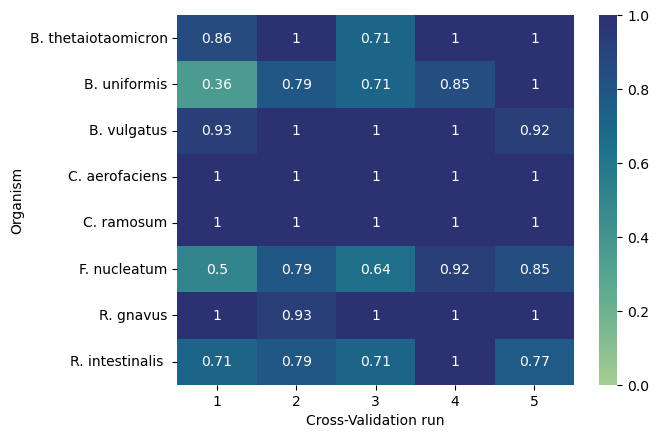

In [ ]:
# Accuracy CV matrix
ax = sns.heatmap(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy"),
                 vmin=0, vmax=1.0, annot=True, cmap=sns.color_palette("crest", as_cmap=True))
plt.savefig('../../runs/ML/annot/multi_layer_perceptron/heatmap_accuracies_1.png')  

In [ ]:
plot_cv_confmat(ys=ys, target_labels=metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy").index,
                accuracies=np.mean(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Accuracy").values, axis=1),
                confusion_matrices=np.sum(metrics_df.pivot(index="Organism", columns="Cross-Validation run", values="Conf_Mat").values, axis=1),
				outdir="../../runs/ML/annot/multi_layer_perceptron", name="class_annot_test_smac")

Index(['B. thetaiotaomicron', 'B. uniformis', 'B. vulgatus', 'C. aerofaciens',
       'C. ramosum', 'F. nucleatum', 'R. gnavus', 'R. intestinalis '],
      dtype='object', name='Organism')